# Fast affine methods in lagomorph

In this notebook I'll just demo some simple affine matching methods in lagomorph, namely matching and atlas building without any intermediate data structures besides gradients with respect to the transforms themselves.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize']=[10,7]

In [3]:
import pycuda.autoinit
from pycuda import gpuarray
from matching import circle_image
import lagomorph as lm

/home/4jh/miniconda3x86_64/envs/lagomorph/lib/python3.6/site-packages/lagomorph/cudamod.py:5: UserWarning: Module lagomorph was already imported from /home/4jh/miniconda3x86_64/envs/lagomorph/lib/python3.6/site-packages/lagomorph/__init__.py, but /home/4jh/git/lagomorph/examples is being added to sys.path
  from pkg_resources import resource_filename


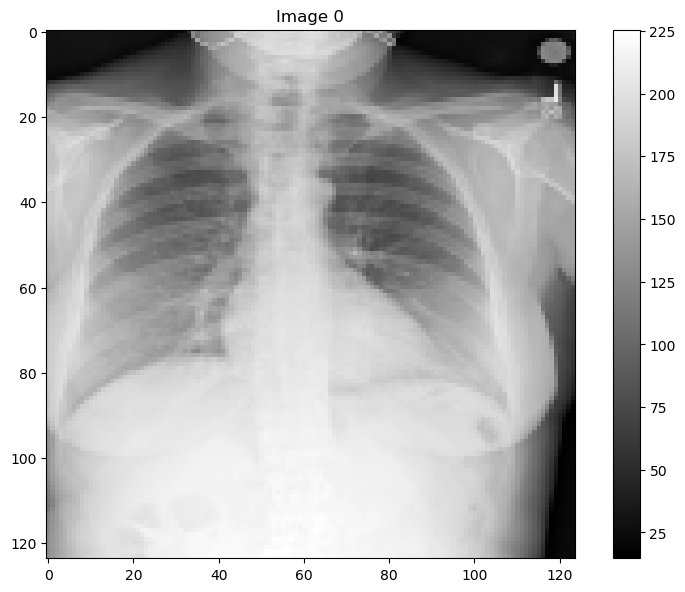

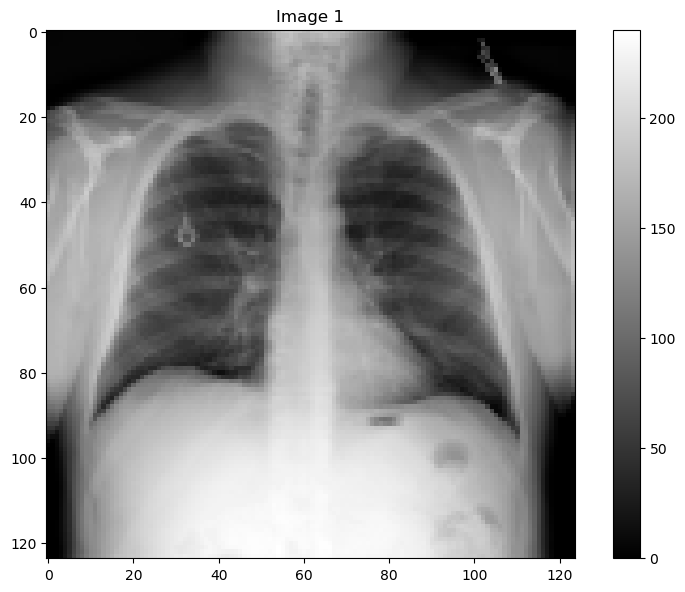

In [4]:
import h5py
with h5py.File('/raid/ChestXRay14/chestxray14_128.h5', 'r') as f:
    # I crop the boundary pixels out since they are often introduce discontinuities
    Jxhost = np.asarray(f['/images/train'][:,2:-2,2:-2], dtype=np.float32)
Jx = gpuarray.to_gpu(Jxhost)
for n in range(min(Jx.shape[0],2)):
    plt.figure()
    plt.imshow(Jx[n,...].get(), cmap='gray')
    plt.title(f'Image {n}')
    plt.colorbar()

CPU times: user 1.61 s, sys: 304 ms, total: 1.92 s
Wall time: 1.07 s


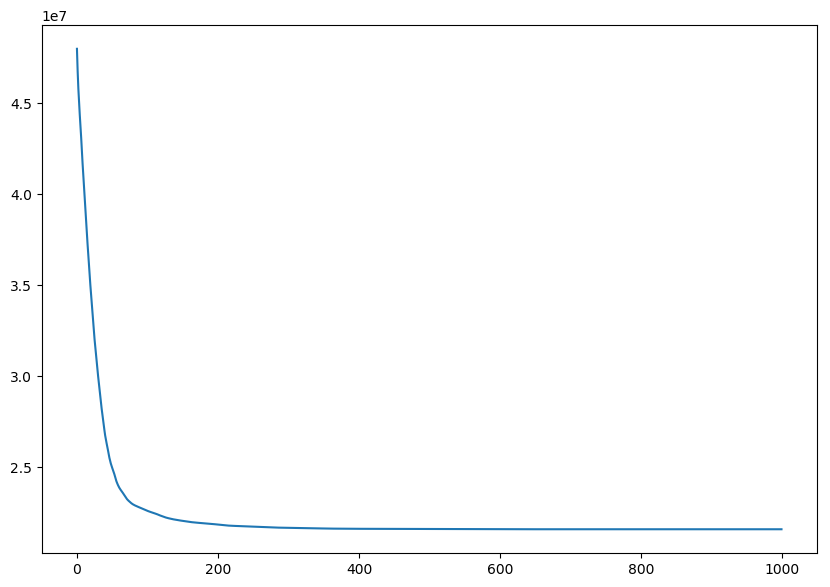

In [5]:
def match_affine(I, J, num_iters=1000, step_size_A=1e-10, step_size_T=1e-7, A=None, T=None):
    # initialize to identity transform
    if A is None:
        A = np.zeros((1,2,2), dtype=Jx.dtype)
        A[:,0,0] = 1
        A[:,1,1] = 1
        A = gpuarray.to_gpu(A)
    if T is None:
        T = gpuarray.zeros((1,2), dtype=Jx.dtype)
    dA = gpuarray.empty_like(A)
    dT = gpuarray.empty_like(T)
    losses = []
    for it in range(num_iters):
        dA.fill(0)
        dT.fill(0)
        dA, dT, loss = lm.affine_gradient(I, J, A, T, outdA=dA, outdT=dT)
        lm.multiply_add(dA, -step_size_A, out=A)
        lm.multiply_add(dT, -step_size_T, out=T)
        losses.append(loss)
    return A, T, losses
J1 = Jx[2:3,...]
J2 = Jx[15:16,...]
%time A, T, losses = match_affine(J1, J2)
plt.plot(losses)

[[[ 0.7901995  -0.05011665]
  [-0.02564938  1.158715  ]]] [[-3.454619  6.432108]]


Text(0.5,1,'J1 matched to J2')

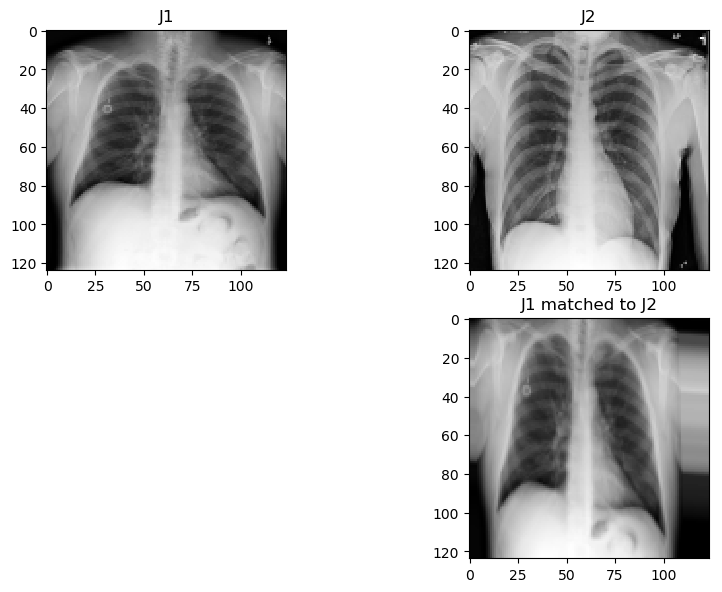

In [6]:
# check that the match makes sense
print(A.get(), T.get())
plt.subplot(2,2,1)
plt.imshow(J1.get().squeeze(), cmap='gray')
plt.title('J1')
plt.subplot(2,2,2)
plt.imshow(J2.get().squeeze(), cmap='gray')
plt.title('J2')
plt.subplot(2,2,4)
plt.imshow(lm.interp_image_affine(J1, A, T).get().squeeze(), cmap='gray')
plt.title('J1 matched to J2')

## Atlas building

To build an affine atlas, we will perform alternating optimization, wherein we will match all the images to the template with $N$ steps of fixed step size gradient descent, just as above. Then we will update the template, which has a closed form solution for the optimum, then we will perform another $N$ steps of gradient descent for the pose, and so on.

In [7]:
def update_base_image(J, A, T, I=None):
    if I is None:
        Ish = tuple([1] + list(J.shape[1:]))
        I = gpuarray.empty(shape=Ish, dtype=J.dtype, allocator=J.allocator)
    #Jcontr = gpuarray.to_gpu((J.get() - contrast_offset[:,None,None]).astype(J.dtype))
    splatJ, w = lm.splat_image_affine(J, A, T)
    #splatJ = gpuarray.to_gpu((splatJ.get()*contrast_scale[:,None,None]).astype(splatJ.dtype))
    #w = gpuarray.to_gpu((w.get()*contrast_scale[:,None,None]).astype(w.dtype))
    sumJ = lm.sum_along_axis(splatJ, axis=0)                                    
    sumw = lm.sum_along_axis(w, axis=0)                                         
    lm.clip_below(sumw, .001, out=sumw) # avoid divide by zero
    I = sumJ/sumw
    # use contrast
    #Icontr_host = np.tile(I.get(), (J.shape[0],1,1))*contrast_scale[:,None,None] + contrast_offset[:,None,None]
    #Icontr = gpuarray.to_gpu(Icontr_host.astype(I.dtype))
    return I
def atlas_affine(J, num_iters=10, N_affine=100, step_size_A=1e-10, step_size_T=1e-7, I=None):
    losses = []
    A = np.zeros((J.shape[0],2,2), dtype=J.dtype)
    A[:,0,0] = 1
    A[:,1,1] = 1
    A = gpuarray.to_gpu(A, allocator=J.allocator)
    T = gpuarray.zeros((J.shape[0],2), dtype=J.dtype, allocator=J.allocator)
    for it in range(num_iters):
        I = update_base_image(J, A, T, I=I)
        #plt.figure();plt.imshow(I.get().squeeze(), cmap='gray');plt.title(f'Base image at outer loop iter {it}')
        A, T, losses_pose = match_affine(I, J, N_affine, step_size_A, step_size_T, A=A, T=T)
        losses.extend(losses_pose)
    return I, A, T, losses
J = Jx[:,...]
%time I, A, T, losses_atlas = atlas_affine(J)

CPU times: user 18min 47s, sys: 7min 55s, total: 26min 43s
Wall time: 27min 1s


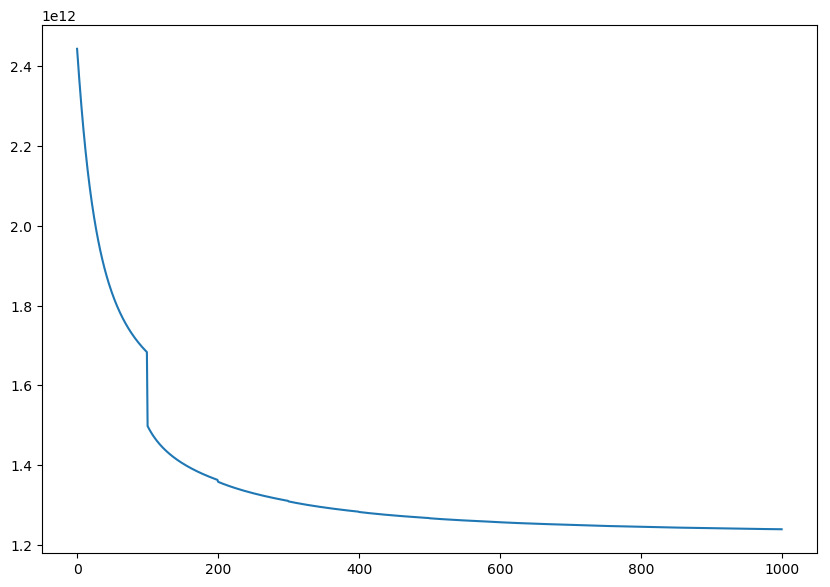

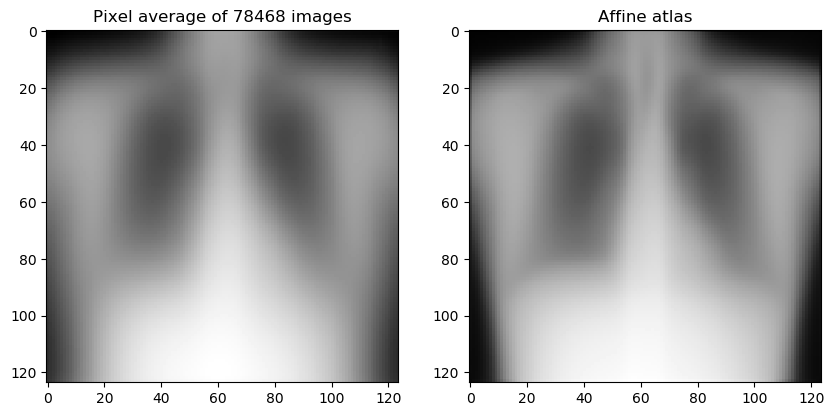

In [8]:
plt.plot(losses_atlas)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(lm.sum_along_axis(J, axis=0).get().squeeze(), cmap='gray')
plt.title(f'Pixel average of {J.shape[0]} images')
plt.subplot(1,2,2)
plt.imshow(I.get().squeeze(), cmap='gray')
_=plt.title('Affine atlas')